100%|██████████| 26.4M/26.4M [00:01<00:00, 18.1MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.01MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.98MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training without Active Learning:
Epoch 1/10, Loss: 0.8833308704990022
Epoch 2/10, Loss: 0.5095622171746924
Epoch 3/10, Loss: 0.43395543700837075
Epoch 4/10, Loss: 0.3921117833320131
Epoch 5/10, Loss: 0.3622837526367066
Epoch 6/10, Loss: 0.3367021080661327
Epoch 7/10, Loss: 0.3258993906226564
Epoch 8/10, Loss: 0.30901212657385685
Epoch 9/10, Loss: 0.2988843375698049
Epoch 10/10, Loss: 0.2848353355805925
Validation Accuracy without Active Learning: 88.95%
Training with Active Learning:
Epoch 1/10, Loss: 0.8909436445487173
Epoch 2/10, Loss: 0.5060583375002209
Epoch 3/10, Loss: 0.4292521498705211
Epoch 4/10, Loss: 0.3903513513113323
Epoch 5/10, Loss: 0.3644379280115429
Epoch 6/10, Loss: 0.34246583518229035
Epoch 7/10, Loss: 0.3258314356992119
Epoch 8/10, Loss: 0.31050844521898974
Epoch 9/10, Loss: 0.2937867953589088
Epoch 10/10, Loss: 0.2874079238427313
Validation Accuracy with Active Learning: 88.8%


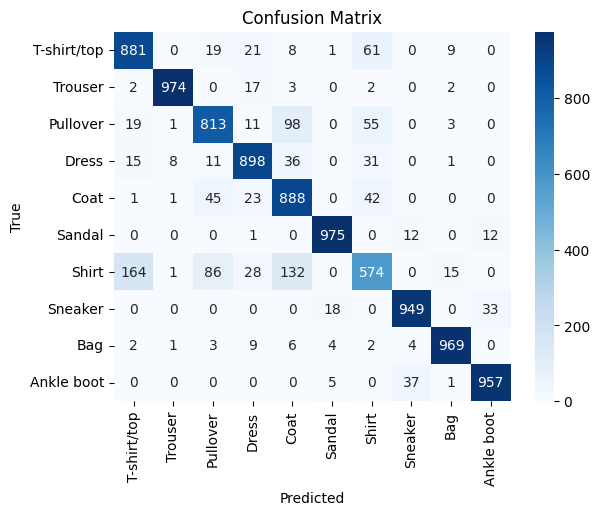

Confusion Matrix - With Active Learning:


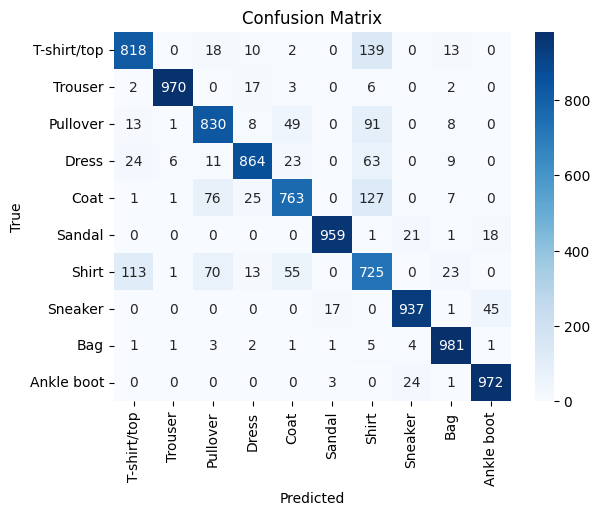

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from scipy.stats import entropy

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load dataset
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Split the training dataset
X_train, X_validation, y_train, y_validation = train_test_split(
    train_dataset.data.numpy(), train_dataset.targets.numpy(), test_size=0.2, random_state=2020
)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1) / 255
X_validation = torch.tensor(X_validation, dtype=torch.float32).unsqueeze(1) / 255
y_train = torch.tensor(y_train, dtype=torch.long)
y_validation = torch.tensor(y_validation, dtype=torch.long)

X_test = torch.tensor(test_dataset.data.numpy(), dtype=torch.float32).unsqueeze(1) / 255
y_test = torch.tensor(test_dataset.targets.numpy(), dtype=torch.long)

# Create data loaders
def create_data_loader(X, y, batch_size):
    return DataLoader(TensorDataset(X, y), batch_size=batch_size, shuffle=True)

train_loader = create_data_loader(X_train, y_train, batch_size=512)
validation_loader = create_data_loader(X_validation, y_validation, batch_size=512)
test_loader = create_data_loader(X_test, y_test, batch_size=512)

# Define CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define training function
def train_model(model, train_loader, criterion, optimizer, device, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

# Define evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Active Learning - Metrics
def least_confidence(predictions):
    confidences, _ = predictions.max(dim=1)
    return confidences.argsort()

def prediction_entropy(predictions):
    probabilities = torch.softmax(predictions, dim=1)
    entropies = entropy(probabilities.cpu().numpy(), axis=1)
    return torch.tensor(entropies).argsort(descending=True)

def margin_sampling(predictions):
    probabilities = torch.softmax(predictions, dim=1)
    top2_probs, _ = probabilities.topk(2, dim=1)
    margins = top2_probs[:, 0] - top2_probs[:, 1]
    return margins.argsort()

def cosine_similarity_metric(features):
    similarities = cosine_similarity(features.cpu().numpy())
    diversities = 1 - similarities.sum(axis=1)
    return torch.tensor(diversities).argsort(descending=True)

def combined_uncertainty_diversity(predictions, features, alpha=0.7):
    uncertainty_scores = prediction_entropy(predictions).cpu().numpy()
    diversity_scores = cosine_similarity_metric(features).cpu().numpy()
    combined_scores = alpha * uncertainty_scores + (1 - alpha) * diversity_scores
    return np.argsort(combined_scores)

# Active Learning Selection Function
def active_learning_selection(model, loader, device, selection_method, n_samples=100, alpha=0.7):
    model.eval()
    all_indices = []
    all_scores = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            features = inputs.view(inputs.size(0), -1)  # Flatten features
            if selection_method in [least_confidence, prediction_entropy, margin_sampling]:
                scores = selection_method(outputs)
            else:
                scores = selection_method(outputs, features, alpha)
            all_indices.extend(range(len(labels)))
            all_scores.extend(scores)
    selected_indices = np.argsort(all_scores)[:n_samples]
    return np.array(all_indices)[selected_indices]

# Metric calculations for selected samples
def calculate_metrics(model, loader, selected_indices, device):
    model.eval()
    metrics = {
        "least_confidence": [],
        "prediction_entropy": [],
        "margin_sampling": [],
        "cosine_similarity": [],
        "l2_norm": [],
        "kl_divergence": [],
    }
    all_features = []
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features = inputs.view(inputs.size(0), -1)  # Flatten features
            all_features.append(features)

            # Least Confidence
            confidences, _ = torch.max(torch.softmax(outputs, dim=1), dim=1)
            least_confidence = 1 - confidences
            metrics["least_confidence"].extend(least_confidence.cpu().numpy())

            # Prediction Entropy
            probabilities = torch.softmax(outputs, dim=1)
            entropies = entropy(probabilities.cpu().numpy(), axis=1)
            metrics["prediction_entropy"].extend(entropies)

            # Margin Sampling
            top2_probs, _ = probabilities.topk(2, dim=1)
            margin = top2_probs[:, 0] - top2_probs[:, 1]
            metrics["margin_sampling"].extend(margin.cpu().numpy())

            # L2 Norm
            l2_norm = torch.norm(features, p=2, dim=1)
            metrics["l2_norm"].extend(l2_norm.cpu().numpy())

            # KL Divergence
            uniform_dist = torch.ones_like(probabilities) / probabilities.size(1)
            kl_div = torch.sum(probabilities * (torch.log(probabilities + 1e-10) - torch.log(uniform_dist + 1e-10)), dim=1)
            metrics["kl_divergence"].extend(kl_div.cpu().numpy())

    # Combine all features for cosine similarity calculation
    all_features = torch.cat(all_features, dim=0)
    cosine_similarities = cosine_similarity(all_features.cpu().numpy())
    diversities = 1 - np.sum(cosine_similarities, axis=1)
    metrics["cosine_similarity"].extend(diversities)

    # Filter metrics for selected indices
    for key in metrics:
        metrics[key] = np.array(metrics[key])[selected_indices]

    # Calculate averages
    averages = {key: np.mean(values) for key, values in metrics.items()}
    return averages

# Train and evaluate without active learning
model_without_al = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_without_al.parameters(), lr=0.001)

print("Training without Active Learning:")
train_model(model_without_al, train_loader, criterion, optimizer, device, epochs=10)
validation_accuracy_without_al = evaluate_model(model_without_al, validation_loader, device)
print(f'Validation Accuracy without Active Learning: {validation_accuracy_without_al}%')

# Active Learning
selected_indices = active_learning_selection(
    model_without_al, validation_loader, device, combined_uncertainty_diversity, n_samples=500
)
X_selected = X_validation[selected_indices]
y_selected = y_validation[selected_indices]
X_train_al = torch.cat([X_train, X_selected])
y_train_al = torch.cat([y_train, y_selected])
train_loader_al = create_data_loader(X_train_al, y_train_al, batch_size=512)

# Train and evaluate with active learning
model_with_al = CNNModel().to(device)
optimizer_al = optim.Adam(model_with_al.parameters(), lr=0.001)

print("Training with Active Learning:")
train_model(model_with_al, train_loader_al, criterion, optimizer_al, device, epochs=10)
validation_accuracy_with_al = evaluate_model(model_with_al, validation_loader, device)
print(f'Validation Accuracy with Active Learning: {validation_accuracy_with_al}%')

# Calculate metrics for selected samples
selected_metrics = calculate_metrics(model_without_al, validation_loader, selected_indices, device)

# Print the results
print("Metrics for selected samples:")
for metric, value in selected_metrics.items():
    print(f"Average {metric.replace('_', ' ').title()}: {value:.4f}")

# Plot confusion matrix
def plot_confusion_matrix(model, loader, device, class_names):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = test_dataset.classes
print("Confusion Matrix - Without Active Learning:")
plot_confusion_matrix(model_without_al, test_loader, device, class_names)

print("Confusion Matrix - With Active Learning:")
plot_confusion_matrix(model_with_al, test_loader, device, class_names)